In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#path = kagglehub.dataset_download("prajwaldongre/loan-application-and-transaction-fraud-detection")

In [3]:
df1 = pd.read_csv("/home/mousefish/.cache/kagglehub/datasets/prajwaldongre/loan-application-and-transaction-fraud-detection/versions/1/loan_applications.csv")  # уточните название файла

In [4]:
df2 = pd.read_csv("/home/mousefish/.cache/kagglehub/datasets/prajwaldongre/loan-application-and-transaction-fraud-detection/versions/1/transactions.csv")  # уточните название файла

In [5]:
# Выбор категориальных столбцов
cat_columns1 = [
    'loan_type',
    'purpose_of_loan',
    'employment_status',
    'property_ownership_status',
    'gender',
    'loan_status'
]
cat_columns1 = df1[cat_columns1]
# Выбор числовых столбцов 
# Список числовых столбцов для обработки
numeric_cols = [
    'loan_amount_requested', 
    'loan_tenure_months',
    'interest_rate_offered',
    'monthly_income',
    'cibil_score',
    'existing_emis_monthly',
    'debt_to_income_ratio',
    'applicant_age',
    'number_of_dependents'
]
mean_values1 = df1[numeric_cols].mean()

In [6]:
# Выбор числовых столбцов
numeric_columns2 = df2.select_dtypes(include=['float64']).columns
mean_values2 = df2[numeric_columns2].mean()

In [7]:
def calculate_emi(row):
    principal = row['loan_amount_requested']
    rate = row['interest_rate_offered'] / 1200  # Месячная ставка
    tenure = row['loan_tenure_months']
    
    if rate == 0:
        return principal / tenure
    else:
        factor = (1 + rate) ** tenure
        return principal * rate * factor / (factor - 1)

df1['monthly_loan_payment'] = df1.apply(calculate_emi, axis=1)

In [8]:
df1['total_monthly_obligations'] = df1['existing_emis_monthly'] + df1['monthly_loan_payment']
df1['obligation_to_income_ratio'] = df1['total_monthly_obligations'] / df1['monthly_income']
df1['application_date'] = pd.to_datetime(df1['application_date'])
df1['application_month'] = df1['application_date'].dt.month
df1['application_weekday'] = df1['application_date'].dt.dayofweek  # 0=понедельник, 6=воскресенье
bins = [20, 30, 40, 50, 60, 70]
labels = ['20-29', '30-39', '40-49', '50-59', '60+']
df1['age_group'] = pd.cut(df1['applicant_age'], bins=bins, labels=labels, right=False)

In [9]:
print(df1[['monthly_loan_payment', 'total_monthly_obligations', 
           'obligation_to_income_ratio', 'application_month', 
           'application_weekday', 'age_group']].head())


   monthly_loan_payment  total_monthly_obligations  \
0          53568.646498               54668.646498   
1           1216.018714                1216.018714   
2           9457.190714               14057.190714   
3           4346.534187                8346.534187   
4           3424.566586                4524.566586   

   obligation_to_income_ratio  application_month  application_weekday  \
0                    1.575465                  4                    6   
1                    0.023566                  9                    5   
2                    0.949810                  5                    0   
3                    0.289810                  7                    1   
4                    0.103065                 11                    0   

  age_group  
0     20-29  
1     40-49  
2     50-59  
3     20-29  
4     50-59  


In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   application_id              50000 non-null  object        
 1   customer_id                 50000 non-null  object        
 2   application_date            50000 non-null  datetime64[ns]
 3   loan_type                   50000 non-null  object        
 4   loan_amount_requested       50000 non-null  float64       
 5   loan_tenure_months          50000 non-null  int64         
 6   interest_rate_offered       50000 non-null  float64       
 7   purpose_of_loan             50000 non-null  object        
 8   employment_status           50000 non-null  object        
 9   monthly_income              50000 non-null  float64       
 10  cibil_score                 50000 non-null  int64         
 11  existing_emis_monthly       50000 non-null  float64   

In [11]:
df1['fraud_type'] = df1['fraud_type'].fillna('No Fraud')
# Удаление полных дубликатов
df1 = df1.drop_duplicates()

# Удаление дубликатов по application_id (сохраняем первое вхождение)
df1 = df1.drop_duplicates(subset=['application_id'], keep='first')
for col in numeric_cols:
    # Расчёт квартилей и IQR
    Q1 = df1[col].quantile(0.25)
    Q3 = df1[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Определение границ
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Замена выбросов на граничные значения
    df1[col] = np.where(df1[col] < lower_bound, lower_bound, df1[col])
    df1[col] = np.where(df1[col] > upper_bound, upper_bound, df1[col])
# Корректировка возраста
df1['applicant_age'] = df1['applicant_age'].clip(21, 65)

# Корректировка числа иждивенцев
df1['number_of_dependents'] = df1['number_of_dependents'].clip(0, 4)

# Недопущение отрицательной долговой нагрузки
df1['debt_to_income_ratio'] = df1['debt_to_income_ratio'].clip(lower=0)

In [12]:
# Проверка пропусков
print("Пропуски после обработки:")
print(df1.isnull().sum())

# Проверка статистик
print("\nОписательные статистики после обработки:")
print(df1.describe())

# Проверка уникальных значений
print("\nУникальные значения в категориальных столбцах:")
print(df1[['fraud_type', 'employment_status', 'property_ownership_status']].nunique())

Пропуски после обработки:
application_id                0
customer_id                   0
application_date              0
loan_type                     0
loan_amount_requested         0
loan_tenure_months            0
interest_rate_offered         0
purpose_of_loan               0
employment_status             0
monthly_income                0
cibil_score                   0
existing_emis_monthly         0
debt_to_income_ratio          0
property_ownership_status     0
residential_address           0
applicant_age                 0
gender                        0
number_of_dependents          0
loan_status                   0
fraud_flag                    0
fraud_type                    0
monthly_loan_payment          0
total_monthly_obligations     0
obligation_to_income_ratio    0
application_month             0
application_weekday           0
age_group                     0
dtype: int64

Описательные статистики после обработки:
                 application_date  loan_amount_requeste

Распределение классов:
fraud_flag
0    97.948
1     2.052
Name: proportion, dtype: float64


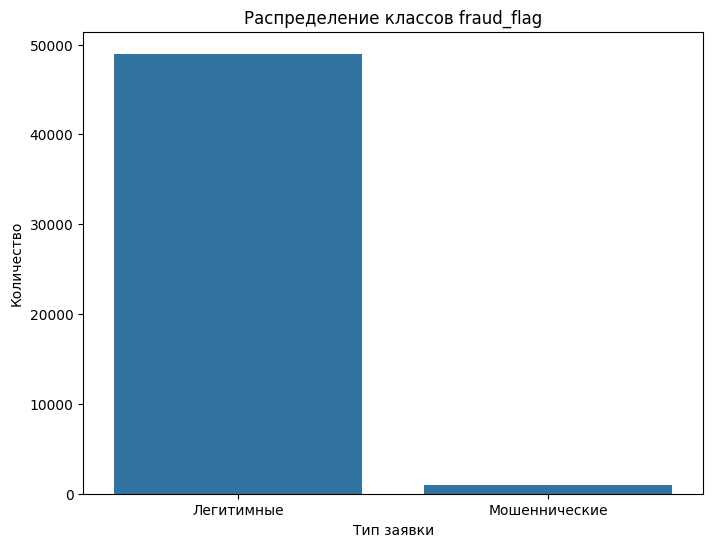

In [13]:
# Анализ распределения классов
fraud_distribution = df1['fraud_flag'].value_counts(normalize=True) * 100

print(f"Распределение классов:")
print(fraud_distribution)

# Визуализация
plt.figure(figsize=(8, 6))
sns.countplot(x='fraud_flag', data=df1)
plt.title('Распределение классов fraud_flag')
plt.xlabel('Тип заявки')
plt.ylabel('Количество')
plt.xticks([0, 1], ['Легитимные', 'Мошеннические'])
plt.show()

In [14]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Выделяем признаки и целевую переменную
features = ['loan_amount_requested', 'monthly_income', 'cibil_score', 
            'debt_to_income_ratio', 'total_monthly_obligations', 'applicant_age']
X = df1[features]
y = df1['fraud_flag']

# Балансировка классов с SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.3, random_state=42, stratify=y_res
)

# Стандартизация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

kNN Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.70      0.80     14693
           1       0.76      0.96      0.85     14692

    accuracy                           0.83     29385
   macro avg       0.86      0.83      0.83     29385
weighted avg       0.86      0.83      0.83     29385

ROC-AUC: 0.9200


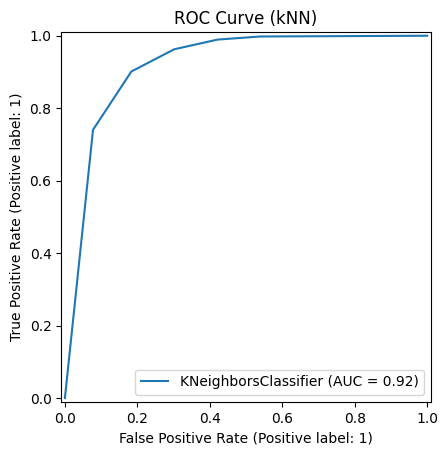

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay

# Обучение kNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Предсказания
y_pred_knn = knn.predict(X_test_scaled)
y_proba_knn = knn.predict_proba(X_test_scaled)[:, 1]

# Оценка метрик
print("kNN Classification Report:")
print(classification_report(y_test, y_pred_knn))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_knn):.4f}")

# Визуализация ROC-кривой
RocCurveDisplay.from_estimator(knn, X_test_scaled, y_test)
plt.title('ROC Curve (kNN)')
plt.show()


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.24      0.37     14693
           1       0.56      0.97      0.71     14692

    accuracy                           0.60     29385
   macro avg       0.72      0.60      0.54     29385
weighted avg       0.72      0.60      0.54     29385

ROC-AUC: 0.6175


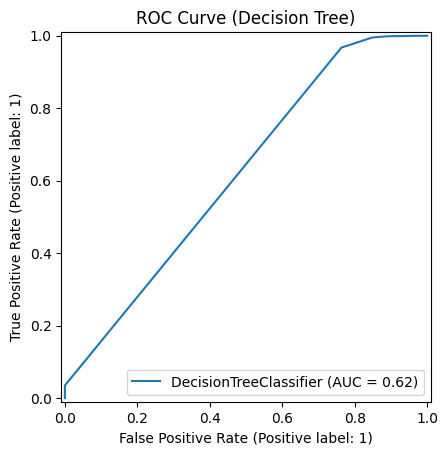

In [19]:
from sklearn.tree import DecisionTreeClassifier

# Обучение дерева решений
dtree = DecisionTreeClassifier(max_depth=5, random_state=42)
dtree.fit(X_train, y_train)  # Деревья не требуют масштабирования

# Предсказания
y_pred_dtree = dtree.predict(X_test)
y_proba_dtree = dtree.predict_proba(X_test)[:, 1]

# Оценка метрик
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_pred_dtree))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_dtree):.4f}")

# Визуализация ROC-кривой
RocCurveDisplay.from_estimator(dtree, X_test, y_test)
plt.title('ROC Curve (Decision Tree)')
plt.show()


Сравнение метрик:


Algorithm  Accuracy  Precision    Recall  F1-score   ROC-AUC    PR-AUC
0            kNN  0.830526   0.761441  0.962633  0.850298  0.920047  0.420325
1  Decision Tree  0.602076   0.558968  0.967465  0.708557  0.617454  0.276958

<Figure size 1200x600 with 0 Axes>

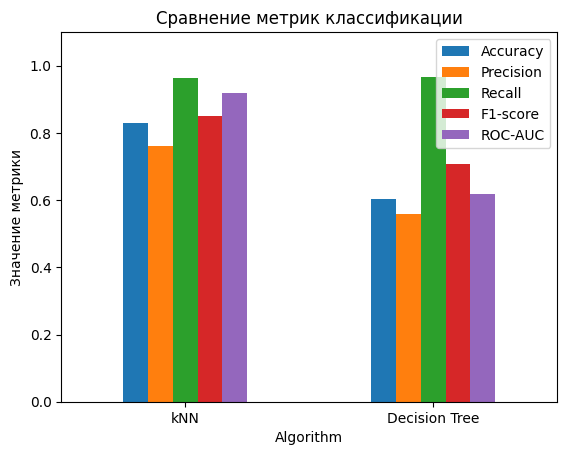

In [18]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    auc,
    classification_report
)
# Создаем DataFrame для сравнения
metrics = {
    'Algorithm': ['kNN', 'Decision Tree'],
    'Accuracy': [
        knn.score(X_test_scaled, y_test),
        dtree.score(X_test, y_test)
    ],
    'Precision': [
        precision_score(y_test, y_pred_knn),
        precision_score(y_test, y_pred_dtree)
    ],
    'Recall': [
        recall_score(y_test, y_pred_knn),
        recall_score(y_test, y_pred_dtree)
    ],
    'F1-score': [
        f1_score(y_test, y_pred_knn),
        f1_score(y_test, y_pred_dtree)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_proba_knn),
        roc_auc_score(y_test, y_proba_dtree)
    ],
    'PR-AUC': [
        auc(*precision_recall_curve(y_test, y_proba_knn)[:2]),
        auc(*precision_recall_curve(y_test, y_proba_dtree)[:2])
    ]
}

metrics_df = pd.DataFrame(metrics)
print("\nСравнение метрик:")
display(metrics_df)

# Визуализация сравнения
plt.figure(figsize=(12, 6))
metrics_df.set_index('Algorithm').drop(['PR-AUC'], axis=1).plot(kind='bar', rot=0)
plt.title('Сравнение метрик классификации')
plt.ylabel('Значение метрики')
plt.ylim(0, 1.1)
plt.legend(loc='upper right')
plt.show()